In [16]:
import os
import os.path
import glob
import time

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold                                                                                                                       
from sklearn.metrics import confusion_matrix,accuracy_score
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import GridSearchCV
import sklearn_evaluation.plot as skplot
from sklearn.model_selection import learning_curve
from sklearn import svm

import matplotlib.pyplot as plt
import matplotlib.cm as colormap

import numpy as np
np.random.seed(1)

from keras.utils import np_utils
from keras.preprocessing import image
from keras.applications.resnet50 import ResNet50
from keras.applications.imagenet_utils import preprocess_input
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.models import Sequential,Model
from keras.layers import Input,Flatten,Dense,Dropout,GlobalAveragePooling2D,Conv2D,MaxPooling2D
from keras.optimizers import SGD

os.environ['CUDA_VISIBLE_DEVICES'] = '1'

In [2]:
imagedir = "Datasets/Original"

In [3]:
cur_dir = os.getcwd()
os.chdir(imagedir)  # the parent folder with sub-folders

# Get number of samples per family
list_fams = sorted(os.listdir(os.getcwd()), key=str.lower)  # vector of strings with family names
no_imgs = []  # No. of samples per family
for i in range(len(list_fams)):
    os.chdir(list_fams[i])
    len1 = len(glob.glob('*.ppm'))  # assuming the images are stored as 'ppm'
    no_imgs.append(len1)
    os.chdir('..')
num_samples = np.sum(no_imgs)  # total number of all samples

# Compute the labels
y = np.zeros(num_samples)
pos = 0
label = 0
for i in no_imgs:
    print ("Label:%2d\tClass: %15s\tNumber of images: %d" % (label, list_fams[label], i))
    for j in range(i):
        y[pos] = label
        pos += 1
    label += 1
num_classes = label

# Compute the features
width, height,channels = (224,224,3)
X = np.zeros((num_samples, width, height, channels))
cnt = 0
list_paths = [] # List of image paths
print("Processing images ...")
for i in range(len(list_fams)):
    for img_file in glob.glob(list_fams[i]+'/*.ppm'):
        #print("[%d] Processing image: %s" % (cnt, img_file))
        list_paths.append(os.path.join(os.getcwd(),img_file))
        img = image.load_img(img_file, target_size=(224, 224))
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        X[cnt] = x
        cnt += 1
print("Images processed: %d" %(cnt))

os.chdir(cur_dir)

Label: 0	Class:     fraterculus	Number of images: 100
Label: 1	Class:         obliqua	Number of images: 101
Label: 2	Class:       sororcula	Number of images: 100
Processing images ...
Images processed: 301


In [4]:
X.shape

(301, 224, 224, 3)

In [5]:
# Encoding classes (y) into integers (y_encoded) and then generating one-hot-encoding (Y)
encoder = LabelEncoder()
encoder.fit(y)
y_encoded = encoder.transform(y)
Y = np_utils.to_categorical(y_encoded)

In [6]:
list_paths

['/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F035-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F025-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F084-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F062-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F021-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F042-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F098-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F115-G-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F048-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F010-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F022-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F006-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F055-1,5x.ppm',
 '/home/edmar/GIT/Moscas/Datasets/Original/fraterculus/F110-G-1,5x.ppm'

In [7]:
# Create stratified k-fold subsets                                                                                                                                        
kfold = 5  # no. of folds
skfind = []
test_fold = np.zeros((num_samples,), dtype=int)-1
for i in range(kfold):
    train_ind = []
    print('Datasets/Folds/Fold-Train%d.txt' %(i+1))
    with open('Datasets/Folds/Fold-Train%d.txt' %(i+1), 'r') as f:
        for fname in f.read().splitlines():
            print('[%d] %s' %(list_paths.index([s for s in list_paths if fname in s][0]),fname))
            train_ind.append(list_paths.index([s for s in list_paths if fname in s][0]))
    print('[%d] Train fold size: %d' %(i,len(train_ind)))
    print(train_ind)
    test_ind = []
    print('Datasets/Folds/Fold-Test%d.txt' %(i+1))
    with open('Datasets/Folds/Fold-Test%d.txt' %(i+1), 'r') as f:
        for fname in f.read().splitlines():
            sample_idx = list_paths.index([s for s in list_paths if fname in s][0])
            print('[%d] %s' %(sample_idx,fname))
            test_ind.append(sample_idx)
            test_fold[sample_idx] = i
    print('[%d] Test fold size: %d' %(i,len(test_ind)))
    print(test_ind)
    #skfind.append((np.array(train_ind),np.array(test_ind)))
    skfind.append((train_ind,test_ind))
print('SKFIND')
print(skfind)
print('TEST_FOLD')
print(test_fold)

Datasets/Folds/Fold-Train1.txt
[11] F006-1,5x.ppm
[66] F009-1,5x.ppm
[68] F016,1,5x.ppm
[10] F022-1,5x.ppm
[33] F027-1,5x.ppm
[30] F033-1,5x.ppm
[39] F037-1,5x.ppm
[67] F041-1,5x.ppm
[77] F050-1,5x.ppm
[96] F054-1,5x.ppm
[41] F063-1,5x.ppm
[23] F072-G-1,5x.ppm
[83] F077-G-1,5x.ppm
[18] F090-G-1,5x.ppm
[44] F093-G-1,5x.ppm
[15] F094-G-1,5x.ppm
[63] F095-G-1,5x.ppm
[99] F106-G-1,5x.ppm
[53] F108-G-1,5x.ppm
[47] F132-N-1,5x.ppm
[254] S093-1,5x.ppm
[216] S094-1,5x.ppm
[288] S095-1,5x.ppm
[213] S096-1,5x.ppm
[279] S098-1,5x.ppm
[207] S099-1,5x.ppm
[209] S100-1,5x.ppm
[259] S101-1,5x.ppm
[300] s102-1,5x.ppm
[268] S103-1,5x.ppm
[278] S104-1,5x.ppm
[251] S105-1,5x.ppm
[267] S106-1,5x.ppm
[281] S108-1,5x.ppm
[244] S109-1,5x.ppm
[229] S111-1,5x.ppm
[247] S112-1,5x.ppm
[208] S116-1,5x.ppm
[261] S118-1,5x.ppm
[234] S123-1,5x.ppm
[131] B001-1,5x.ppm
[193] B003,1,5x.ppm
[140] B009-1,5x.ppm
[167] B012-1,5X.ppm
[195] B018-1,5x.ppm
[162] B019-1,5x.ppm
[158] B024-1,5x.ppm
[110] B032-1,5x.ppm
[137] B038-

[17] F004-1,5x.ppm
[55] F039-1,5x.ppm
[88] F061-1,5x.ppm
[42] F080-G-1,5x.ppm
[19] F026-1,5x.ppm
[87] F064-1,5x.ppm
[20] F028-1,5x.ppm
[97] F056-1,5x.ppm
[94] F091-G-1,5x.ppm
[8] F048-1,5x.ppm
[262] S001-1,5x.ppm
[245] S003-1,5x.ppm
[257] S004-1,5x.ppm
[250] S005-1,5x.ppm
[291] S006-1,5x.ppm
[285] S007-1,5x.ppm
[290] S008-1,5x.ppm
[274] S009-1,5x.ppm
[226] S010-1,5x.ppm
[205] S011-1,5x.ppm
[232] S012-1,5x.ppm
[228] S015-1,5x.ppm
[203] S016-1,5x.ppm
[240] S018-1,5x.ppm
[242] S019-1,5x.ppm
[282] S020-1,5x.ppm
[211] S021-1,5x.ppm
[271] S022-1,5x.ppm
[294] S023-1,5x.ppm
[224] S024-1,5x.ppm
[152] B077-G-1,5x.ppm
[176] B074-G-1,5x.ppm
[160] B056-1,5x.ppm
[155] B061-M-1,5x.ppm
[189] B020-1,5x.ppm
[180] B015-1,5x.ppm
[146] B101-G-1,5x.ppm
[126] B082-G-1,5x.ppm
[115] B093-G-1,5x.ppm
[182] B042-1,5x.ppm
[166] B062-G-1,5x.ppm
[141] B002-1,5x.ppm
[139] B033-15,x.ppm
[130] B049-1,5x.ppm
[145] B083-G-1,5x.ppm
[138] B075-G-1,5x.ppm
[112] B096-G-1,5x.ppm
[135] B086-G-1,5x.ppm
[173] B071-G-1,5x.ppm
[10

In [8]:
# Creating base_model (ResNet50 notop)
image_shape = (224, 224, 3)                                                                                                                                                                                                                                                                                            
base_model = ResNet50(weights='imagenet', input_shape=image_shape, include_top=False, pooling='avg')

In [9]:
# Adding the top layer
predictions = Dense(num_classes, activation='softmax', name='predictions')(base_model.output)
model = Model(inputs=base_model.input, outputs=predictions)

In [10]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['accuracy'])
#model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='categorical_crossentropy', metrics=['accuracy'])

In [11]:
# Fine-tuning the model (base_model + top layer) 
num_epochs=200
history = []
conf_mat = np.zeros((len(list_fams),len(list_fams))) # Initializing the Confusion Matrix
checkpointer = ModelCheckpoint(filepath='moscas-folds-resnet50-finetune.h5', monitor='val_acc', verbose=0, save_best_only=True, save_weights_only=True, mode='auto')
callbacks_list = [checkpointer]
init_weights = model.get_weights()

In [12]:
for i in range(kfold):
    train_indices = skfind[i][0]
    test_indices = skfind[i][1]
    X_train = X[train_indices]
    Y_train = Y[train_indices]
    X_test = X[test_indices]
    Y_test = Y[test_indices]
    y_test = y[test_indices]

    model.set_weights(init_weights)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Initial acurracy: %.4f" %(i,accuracy_score(y_test,y_pred)))

    start = time.time()
    h = model.fit(X_train, Y_train, validation_data=(X_test, Y_test), epochs=num_epochs, batch_size=64, verbose=1, callbacks=callbacks_list)
    end = time.time()
    history.append(h)
    
    y_prob = model.predict(X_test, verbose=1)  # Testing
    y_pred = np.argmax(y_prob, axis=1)
    print("[%d] Test acurracy: %.4f (%.4f s)" %(i,accuracy_score(y_test,y_pred),end-start))
    
    cm = confusion_matrix(y_test,y_pred)  # Compute confusion matrix for this fold
    conf_mat = conf_mat + cm  # Compute global confusion matrix

60/60 [==============================] - 1s     
[0] Initial acurracy: 0.3333
Train on 241 samples, validate on 60 samples
Epoch 1/200
241/241 [==============================] - 12s - loss: 0.9443 - acc: 0.6266 - val_loss: 10.0067 - val_acc: 0.3333
Epoch 2/200
241/241 [==============================] - 2s - loss: 0.2950 - acc: 0.8880 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 3/200
241/241 [==============================] - 2s - loss: 0.0899 - acc: 0.9544 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 4/200
241/241 [==============================] - 2s - loss: 0.0279 - acc: 0.9876 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 5/200
241/241 [==============================] - 2s - loss: 0.0033 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 6/200
241/241 [==============================] - 2s - loss: 0.0108 - acc: 0.9959 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 7/200
241/241 [==============================] - 2s - loss: 0.0084 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
E

241/241 [==============================] - 2s - loss: 2.6757e-05 - acc: 1.0000 - val_loss: 0.6247 - val_acc: 0.9000
Epoch 65/200
241/241 [==============================] - 2s - loss: 1.5117e-05 - acc: 1.0000 - val_loss: 0.6043 - val_acc: 0.9000
Epoch 66/200
241/241 [==============================] - 2s - loss: 1.4259e-05 - acc: 1.0000 - val_loss: 0.5862 - val_acc: 0.8833
Epoch 67/200
241/241 [==============================] - 2s - loss: 3.6413e-06 - acc: 1.0000 - val_loss: 0.5718 - val_acc: 0.8833
Epoch 68/200
241/241 [==============================] - 2s - loss: 3.7948e-06 - acc: 1.0000 - val_loss: 0.5585 - val_acc: 0.8833
Epoch 69/200
241/241 [==============================] - 2s - loss: 9.4305e-06 - acc: 1.0000 - val_loss: 0.5469 - val_acc: 0.8833
Epoch 70/200
241/241 [==============================] - 2s - loss: 6.8545e-06 - acc: 1.0000 - val_loss: 0.5360 - val_acc: 0.8833
Epoch 71/200
241/241 [==============================] - 2s - loss: 9.8799e-06 - acc: 1.0000 - val_loss: 0.5275

241/241 [==============================] - 2s - loss: 1.2707e-05 - acc: 1.0000 - val_loss: 0.4850 - val_acc: 0.8667
Epoch 128/200
241/241 [==============================] - 2s - loss: 6.0050e-07 - acc: 1.0000 - val_loss: 0.4888 - val_acc: 0.8667
Epoch 129/200
241/241 [==============================] - 2s - loss: 1.5567e-06 - acc: 1.0000 - val_loss: 0.4915 - val_acc: 0.8833
Epoch 130/200
241/241 [==============================] - 2s - loss: 1.0237e-06 - acc: 1.0000 - val_loss: 0.4940 - val_acc: 0.8833
Epoch 131/200
241/241 [==============================] - 2s - loss: 7.3356e-07 - acc: 1.0000 - val_loss: 0.4955 - val_acc: 0.8833
Epoch 132/200
241/241 [==============================] - 2s - loss: 1.1048e-06 - acc: 1.0000 - val_loss: 0.4965 - val_acc: 0.8833
Epoch 133/200
241/241 [==============================] - 2s - loss: 1.1048e-06 - acc: 1.0000 - val_loss: 0.4973 - val_acc: 0.8833
Epoch 134/200
241/241 [==============================] - 2s - loss: 3.0915e-06 - acc: 1.0000 - val_loss:

241/241 [==============================] - 2s - loss: 6.1647e-06 - acc: 1.0000 - val_loss: 0.5280 - val_acc: 0.8667
Epoch 191/200
241/241 [==============================] - 2s - loss: 3.5788e-07 - acc: 1.0000 - val_loss: 0.5274 - val_acc: 0.8667
Epoch 192/200
241/241 [==============================] - 2s - loss: 7.8303e-07 - acc: 1.0000 - val_loss: 0.5284 - val_acc: 0.8667
Epoch 193/200
241/241 [==============================] - 2s - loss: 5.7429e-07 - acc: 1.0000 - val_loss: 0.5282 - val_acc: 0.8667
Epoch 194/200
241/241 [==============================] - 2s - loss: 1.1117e-06 - acc: 1.0000 - val_loss: 0.5274 - val_acc: 0.8667
Epoch 195/200
241/241 [==============================] - 2s - loss: 1.0613e-06 - acc: 1.0000 - val_loss: 0.5274 - val_acc: 0.8667
Epoch 196/200
241/241 [==============================] - 2s - loss: 1.7444e-06 - acc: 1.0000 - val_loss: 0.5278 - val_acc: 0.8667
Epoch 197/200
241/241 [==============================] - 2s - loss: 1.5953e-06 - acc: 1.0000 - val_loss:

240/240 [==============================] - 3s - loss: 2.8802e-04 - acc: 1.0000 - val_loss: 0.7314 - val_acc: 0.9016
Epoch 53/200
240/240 [==============================] - 3s - loss: 3.3359e-04 - acc: 1.0000 - val_loss: 0.4715 - val_acc: 0.9344
Epoch 54/200
240/240 [==============================] - 3s - loss: 3.6583e-04 - acc: 1.0000 - val_loss: 0.3449 - val_acc: 0.9508
Epoch 55/200
240/240 [==============================] - 2s - loss: 2.1518e-04 - acc: 1.0000 - val_loss: 0.2602 - val_acc: 0.9508
Epoch 56/200
240/240 [==============================] - 3s - loss: 1.7801e-04 - acc: 1.0000 - val_loss: 0.2083 - val_acc: 0.9672
Epoch 57/200
240/240 [==============================] - 2s - loss: 1.9933e-04 - acc: 1.0000 - val_loss: 0.1858 - val_acc: 0.9508
Epoch 58/200
240/240 [==============================] - 2s - loss: 5.3318e-04 - acc: 1.0000 - val_loss: 0.1556 - val_acc: 0.9508
Epoch 59/200
240/240 [==============================] - 2s - loss: 1.5930e-04 - acc: 1.0000 - val_loss: 0.1305

240/240 [==============================] - 2s - loss: 6.2671e-05 - acc: 1.0000 - val_loss: 0.0766 - val_acc: 0.9672
Epoch 116/200
240/240 [==============================] - 2s - loss: 5.7083e-05 - acc: 1.0000 - val_loss: 0.0688 - val_acc: 0.9672
Epoch 117/200
240/240 [==============================] - 2s - loss: 1.2778e-04 - acc: 1.0000 - val_loss: 0.0633 - val_acc: 0.9672
Epoch 118/200
240/240 [==============================] - 2s - loss: 8.8372e-05 - acc: 1.0000 - val_loss: 0.0580 - val_acc: 0.9672
Epoch 119/200
240/240 [==============================] - 2s - loss: 6.6710e-05 - acc: 1.0000 - val_loss: 0.0535 - val_acc: 0.9672
Epoch 120/200
240/240 [==============================] - 2s - loss: 7.2163e-05 - acc: 1.0000 - val_loss: 0.0499 - val_acc: 0.9672
Epoch 121/200
240/240 [==============================] - 2s - loss: 6.3249e-05 - acc: 1.0000 - val_loss: 0.0466 - val_acc: 0.9672
Epoch 122/200
240/240 [==============================] - 2s - loss: 5.2580e-05 - acc: 1.0000 - val_loss:

240/240 [==============================] - 2s - loss: 2.9134e-05 - acc: 1.0000 - val_loss: 0.0265 - val_acc: 0.9836
Epoch 179/200
240/240 [==============================] - 2s - loss: 2.7604e-05 - acc: 1.0000 - val_loss: 0.0259 - val_acc: 0.9836
Epoch 180/200
240/240 [==============================] - 2s - loss: 2.7796e-05 - acc: 1.0000 - val_loss: 0.0255 - val_acc: 0.9836
Epoch 181/200
240/240 [==============================] - 2s - loss: 2.5485e-05 - acc: 1.0000 - val_loss: 0.0254 - val_acc: 0.9836
Epoch 182/200
240/240 [==============================] - 2s - loss: 2.9646e-05 - acc: 1.0000 - val_loss: 0.0253 - val_acc: 0.9836
Epoch 183/200
240/240 [==============================] - 2s - loss: 4.2244e-05 - acc: 1.0000 - val_loss: 0.0251 - val_acc: 0.9836
Epoch 184/200
240/240 [==============================] - 2s - loss: 3.0703e-05 - acc: 1.0000 - val_loss: 0.0250 - val_acc: 0.9836
Epoch 185/200
240/240 [==============================] - 2s - loss: 2.2406e-05 - acc: 1.0000 - val_loss:

241/241 [==============================] - 2s - loss: 4.5860e-04 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 41/200
241/241 [==============================] - 2s - loss: 3.4796e-04 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 42/200
241/241 [==============================] - 2s - loss: 3.8978e-04 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 43/200
241/241 [==============================] - 2s - loss: 4.1964e-04 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 44/200
241/241 [==============================] - 2s - loss: 5.5379e-04 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 45/200
241/241 [==============================] - 2s - loss: 3.8169e-04 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 46/200
241/241 [==============================] - 2s - loss: 2.7567e-04 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 47/200
241/241 [==============================] - 2s - loss: 4.2783e-04 - acc: 1.0000 - val_loss:

241/241 [==============================] - 2s - loss: 7.8976e-05 - acc: 1.0000 - val_loss: 0.1203 - val_acc: 0.9833
Epoch 104/200
241/241 [==============================] - 2s - loss: 7.9199e-05 - acc: 1.0000 - val_loss: 0.1215 - val_acc: 0.9833
Epoch 105/200
241/241 [==============================] - 2s - loss: 7.5895e-05 - acc: 1.0000 - val_loss: 0.1229 - val_acc: 0.9833
Epoch 106/200
241/241 [==============================] - 2s - loss: 6.0790e-05 - acc: 1.0000 - val_loss: 0.1238 - val_acc: 0.9833
Epoch 107/200
241/241 [==============================] - 2s - loss: 8.6743e-05 - acc: 1.0000 - val_loss: 0.1242 - val_acc: 0.9833
Epoch 108/200
241/241 [==============================] - 2s - loss: 1.2338e-04 - acc: 1.0000 - val_loss: 0.1246 - val_acc: 0.9833
Epoch 109/200
241/241 [==============================] - 2s - loss: 1.2129e-04 - acc: 1.0000 - val_loss: 0.1268 - val_acc: 0.9833
Epoch 110/200
241/241 [==============================] - 2s - loss: 1.5411e-04 - acc: 1.0000 - val_loss:

241/241 [==============================] - 2s - loss: 3.3111e-05 - acc: 1.0000 - val_loss: 0.1291 - val_acc: 0.9667
Epoch 167/200
241/241 [==============================] - 2s - loss: 4.4964e-05 - acc: 1.0000 - val_loss: 0.1298 - val_acc: 0.9667
Epoch 168/200
241/241 [==============================] - 2s - loss: 3.3758e-05 - acc: 1.0000 - val_loss: 0.1304 - val_acc: 0.9667
Epoch 169/200
241/241 [==============================] - 2s - loss: 3.8125e-05 - acc: 1.0000 - val_loss: 0.1312 - val_acc: 0.9667
Epoch 170/200
241/241 [==============================] - 2s - loss: 3.9293e-05 - acc: 1.0000 - val_loss: 0.1316 - val_acc: 0.9667
Epoch 171/200
241/241 [==============================] - 2s - loss: 2.8465e-05 - acc: 1.0000 - val_loss: 0.1326 - val_acc: 0.9667
Epoch 172/200
241/241 [==============================] - 2s - loss: 4.6246e-05 - acc: 1.0000 - val_loss: 0.1332 - val_acc: 0.9667
Epoch 173/200
241/241 [==============================] - 2s - loss: 1.2050e-04 - acc: 1.0000 - val_loss:

241/241 [==============================] - 2s - loss: 0.4294 - acc: 0.9046 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 29/200
241/241 [==============================] - 2s - loss: 0.3630 - acc: 0.9170 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 30/200
241/241 [==============================] - 2s - loss: 0.3080 - acc: 0.9295 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 31/200
241/241 [==============================] - 2s - loss: 0.2786 - acc: 0.9336 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 32/200
241/241 [==============================] - 2s - loss: 0.1604 - acc: 0.9585 - val_loss: 10.2081 - val_acc: 0.3667
Epoch 33/200
241/241 [==============================] - 2s - loss: 0.1702 - acc: 0.9461 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 34/200
241/241 [==============================] - 2s - loss: 0.1123 - acc: 0.9585 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 35/200
241/241 [==============================] - 2s - loss: 0.1178 - acc: 0.9585 - val_loss: 10.7454 - val_acc: 0.3333
Epoch

241/241 [==============================] - 2s - loss: 0.0030 - acc: 1.0000 - val_loss: 0.9463 - val_acc: 0.8333
Epoch 94/200
241/241 [==============================] - 2s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.9118 - val_acc: 0.8500
Epoch 95/200
241/241 [==============================] - 2s - loss: 0.0023 - acc: 1.0000 - val_loss: 0.8998 - val_acc: 0.8500
Epoch 96/200
241/241 [==============================] - 2s - loss: 0.0021 - acc: 1.0000 - val_loss: 0.8927 - val_acc: 0.8500
Epoch 97/200
241/241 [==============================] - 2s - loss: 0.0024 - acc: 1.0000 - val_loss: 0.8864 - val_acc: 0.8500
Epoch 98/200
241/241 [==============================] - 2s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.8819 - val_acc: 0.8500
Epoch 99/200
241/241 [==============================] - 2s - loss: 0.0018 - acc: 1.0000 - val_loss: 0.8737 - val_acc: 0.8667
Epoch 100/200
241/241 [==============================] - 2s - loss: 0.0013 - acc: 1.0000 - val_loss: 0.8667 - val_acc: 0.8667
Epoch 101/20

241/241 [==============================] - 2s - loss: 5.2980e-04 - acc: 1.0000 - val_loss: 0.9948 - val_acc: 0.8667
Epoch 158/200
241/241 [==============================] - 2s - loss: 4.7972e-04 - acc: 1.0000 - val_loss: 0.9731 - val_acc: 0.8833
Epoch 159/200
241/241 [==============================] - 2s - loss: 6.4774e-04 - acc: 1.0000 - val_loss: 0.9581 - val_acc: 0.8833
Epoch 160/200
241/241 [==============================] - 2s - loss: 3.2750e-04 - acc: 1.0000 - val_loss: 0.9482 - val_acc: 0.8833
Epoch 161/200
241/241 [==============================] - 2s - loss: 4.8448e-04 - acc: 1.0000 - val_loss: 0.9371 - val_acc: 0.8833
Epoch 162/200
241/241 [==============================] - 2s - loss: 5.1900e-04 - acc: 1.0000 - val_loss: 0.9272 - val_acc: 0.8833
Epoch 163/200
241/241 [==============================] - 2s - loss: 5.2426e-04 - acc: 1.0000 - val_loss: 0.9254 - val_acc: 0.8833
Epoch 164/200
241/241 [==============================] - 2s - loss: 3.8028e-04 - acc: 1.0000 - val_loss:

241/241 [==============================] - 2s - loss: 0.0118 - acc: 0.9959 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 20/200
241/241 [==============================] - 2s - loss: 0.0149 - acc: 0.9959 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 21/200
241/241 [==============================] - 2s - loss: 0.0058 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 22/200
241/241 [==============================] - 2s - loss: 0.0086 - acc: 0.9959 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 23/200
241/241 [==============================] - 2s - loss: 0.0031 - acc: 1.0000 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 24/200
241/241 [==============================] - 2s - loss: 0.0190 - acc: 0.9959 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 25/200
241/241 [==============================] - 2s - loss: 0.0360 - acc: 0.9834 - val_loss: 10.7454 - val_acc: 0.3333
Epoch 26/200
241/241 [==============================] - 2s - loss: 0.0338 - acc: 0.9876 - val_loss: 10.7454 - val_acc: 0.3333
Epoch

241/241 [==============================] - 2s - loss: 1.5411e-04 - acc: 1.0000 - val_loss: 0.4978 - val_acc: 0.9167
Epoch 84/200
241/241 [==============================] - 2s - loss: 6.2492e-05 - acc: 1.0000 - val_loss: 0.4920 - val_acc: 0.9167
Epoch 85/200
241/241 [==============================] - 2s - loss: 9.5573e-05 - acc: 1.0000 - val_loss: 0.4875 - val_acc: 0.9167
Epoch 86/200
241/241 [==============================] - 2s - loss: 1.7166e-04 - acc: 1.0000 - val_loss: 0.4826 - val_acc: 0.9167
Epoch 87/200
241/241 [==============================] - 2s - loss: 1.3787e-04 - acc: 1.0000 - val_loss: 0.4766 - val_acc: 0.9167
Epoch 88/200
241/241 [==============================] - 2s - loss: 7.4732e-05 - acc: 1.0000 - val_loss: 0.4724 - val_acc: 0.9167
Epoch 89/200
241/241 [==============================] - 2s - loss: 1.3547e-04 - acc: 1.0000 - val_loss: 0.4670 - val_acc: 0.9167
Epoch 90/200
241/241 [==============================] - 2s - loss: 1.0190e-04 - acc: 1.0000 - val_loss: 0.4630

241/241 [==============================] - 2s - loss: 2.9695e-05 - acc: 1.0000 - val_loss: 0.4024 - val_acc: 0.9167
Epoch 147/200
241/241 [==============================] - 2s - loss: 4.2351e-05 - acc: 1.0000 - val_loss: 0.4021 - val_acc: 0.9167
Epoch 148/200
241/241 [==============================] - 2s - loss: 4.0045e-05 - acc: 1.0000 - val_loss: 0.4017 - val_acc: 0.9167
Epoch 149/200
241/241 [==============================] - 2s - loss: 8.0334e-05 - acc: 1.0000 - val_loss: 0.4023 - val_acc: 0.9167
Epoch 150/200
241/241 [==============================] - 2s - loss: 1.1949e-04 - acc: 1.0000 - val_loss: 0.4026 - val_acc: 0.9167
Epoch 151/200
241/241 [==============================] - 2s - loss: 4.5614e-05 - acc: 1.0000 - val_loss: 0.4034 - val_acc: 0.9167
Epoch 152/200
241/241 [==============================] - 2s - loss: 3.4435e-05 - acc: 1.0000 - val_loss: 0.4036 - val_acc: 0.9167
Epoch 153/200
241/241 [==============================] - 2s - loss: 6.7927e-05 - acc: 1.0000 - val_loss:

In [13]:
# Computing the average accuracy
avg_acc = np.trace(conf_mat)/np.sum(conf_mat)
print("Average acurracy: %.4f" %(avg_acc))

Average acurracy: 0.9269


In [14]:
def plot_acc(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['acc'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_acc'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

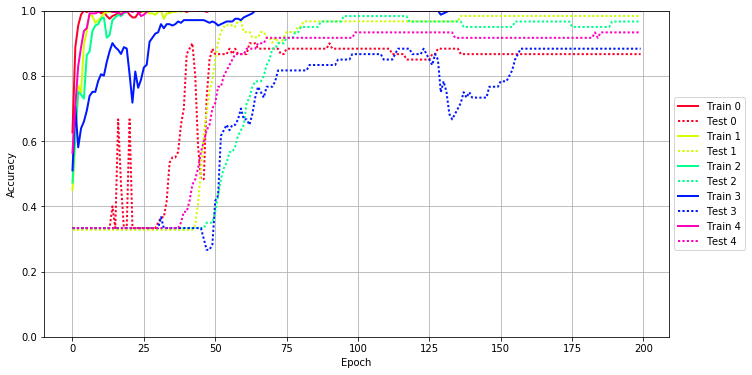

In [17]:
plot_acc(history)

In [18]:
def plot_loss(history):
    figure = plt.gcf()
    figure.set_size_inches(14, 6)
    ax = plt.subplot()
    #plt.title('Loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    colors = iter(colormap.gist_rainbow(np.linspace(0, 1, len(history))))
    for i in range(len(history)):
        color=next(colors)
        plt.plot(history[i].history['loss'], label='Train '+str(i), color=color, linestyle = 'solid', linewidth=2.0)
        plt.plot(history[i].history['val_loss'], label='Test '+str(i), color=color, linestyle = 'dotted', linewidth=2.0)
    plt.legend()
    box = ax.get_position()
    ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax.legend(loc='center left', bbox_to_anchor=(1, 0.5))
    plt.grid(True)
    plt.show()

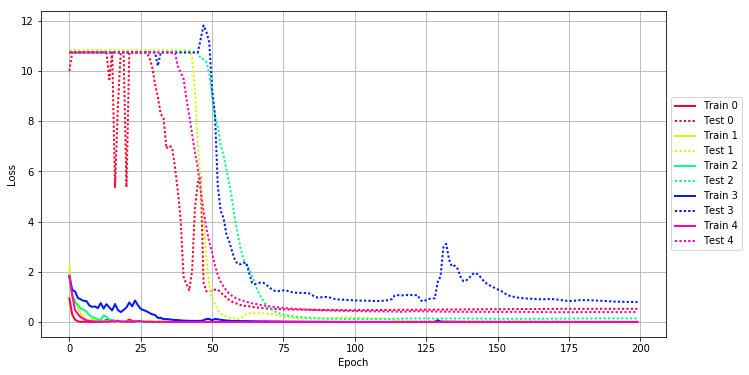

In [19]:
plot_loss(history)

Plotting the confusion matrix


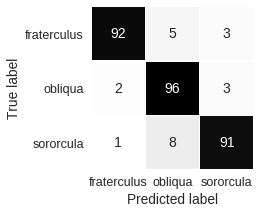

In [20]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix")
figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat, cbar=False, annot=True, square=True,
                 fmt='.0f', annot_kws={'size': 14}, linewidth = 0.2, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

Plotting the confusion matrix normalized


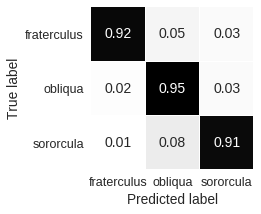

In [21]:
import seaborn as sns
plt.style.use('seaborn-whitegrid')

print("Plotting the confusion matrix normalized")
conf_mat_norm = conf_mat/np.sum(conf_mat,axis=1)  # Normalizing the confusion matrix
conf_mat_norm = np.around(conf_mat_norm,decimals=2)  # rounding to display in figure

figure = plt.gcf()
figure.set_size_inches(4, 3)
sns.set(font_scale=1.25)
hm = sns.heatmap(conf_mat_norm, cbar=False, annot=True, square=True,
                 fmt='.2f', annot_kws={'size': 14}, linewidth = 0.1, cmap = 'binary',
                 yticklabels=list_fams, xticklabels=list_fams)
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()

In [22]:
for h in history:
    print(h.history)

{'acc': [0.62655599829566921, 0.88796679483904384, 0.95435683633281976, 0.98755186919849447, 1.0, 0.99585062438521643, 1.0, 1.0, 1.0, 1.0, 0.99170124679185545, 0.99585061226642968, 0.98340247132471492, 0.97510371613799285, 0.98340248962655596, 0.98755185707970772, 0.99170124481327804, 1.0, 0.99585062240663902, 1.0, 0.98755186721991706, 0.97925311203319498, 0.97925311203319498, 0.99170124481327804, 0.99585062240663902, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0,

In [23]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0].history['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['acc']
    test_scores = np.zeros((len(history),len(history[0].history['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_acc']
    epochs = np.linspace(0, len(history[0].history['acc']), len(history[0].history['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.0))
    plt.show()

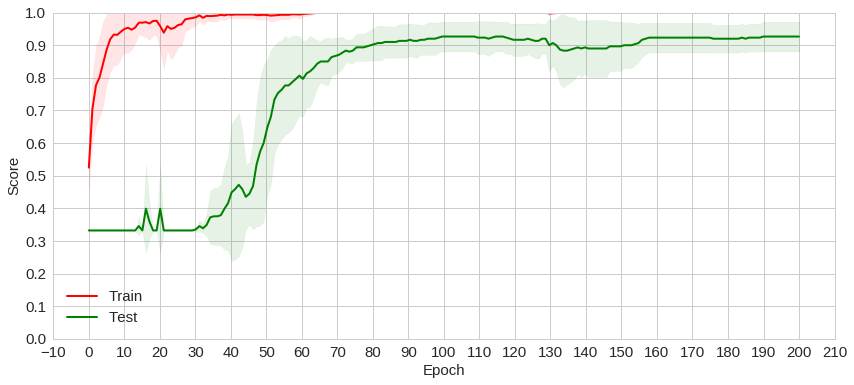

In [24]:
plot_mean_acc(history)

In [25]:
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0].history['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold].history['loss']
    test_scores = np.zeros((len(history),len(history[0].history['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold].history['val_loss']
    epochs = np.linspace(0, len(history[0].history['loss']), len(history[0].history['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    plt.show()

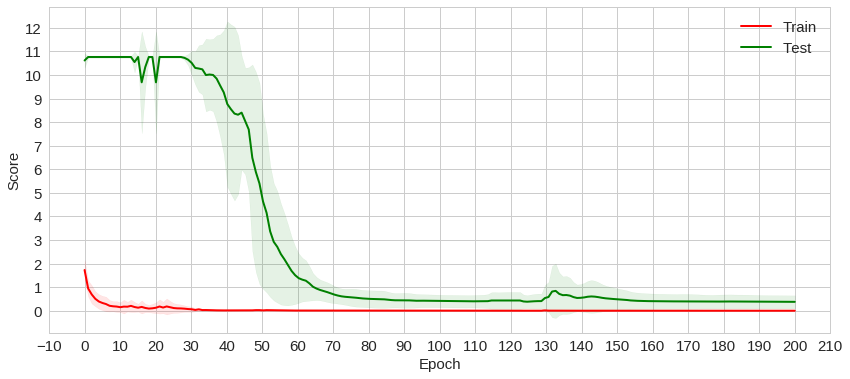

In [26]:
plot_mean_loss(history)

In [28]:
hist = [{'acc': [0.62655599829566921, 0.88796679483904384, 0.95435683633281976, 0.98755186919849447, 1.0, 0.99585062438521643, 1.0, 1.0, 1.0, 1.0, 0.99170124679185545, 0.99585061226642968, 0.98340247132471492, 0.97510371613799285, 0.98340248962655596, 0.98755185707970772, 0.99170124481327804, 1.0, 0.99585062240663902, 1.0, 0.98755186721991706, 0.97925311203319498, 0.97925311203319498, 0.99170124481327804, 0.99585062240663902, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [0.94433132271549014, 0.29499249917713932, 0.089924280496924747, 0.027861007485399603, 0.0033003183958966948, 0.010829653985087308, 0.0084109806158112286, 0.0014104098757860325, 0.00087683701537997767, 0.0053986171337764297, 0.010819861047062637, 0.0094691156506291063, 0.025972359748054837, 0.088431973553251053, 0.073558286667117445, 0.050649620809001053, 0.018172492611287665, 0.010911089457045947, 0.013285147985762287, 0.00058290949337671345, 0.027866949686680097, 0.099371548123750444, 0.041724267342278569, 0.025941609478404907, 0.011281823944223125, 0.0018016298330984083, 0.0094497533028663223, 0.0049290083548251184, 0.0052960031546064931, 0.00028145937437454386, 0.0011604569467843445, 4.8559939515215626e-05, 0.0023311007665508887, 0.00019431412577459054, 0.01086850400315975, 3.2608852776939325e-05, 0.00098062036172393854, 0.00016407878023400299, 0.0004337525065974777, 0.00052702147052465127, 0.0080834745479693559, 0.00030321581735994466, 0.0018286203113684037, 0.0017594650016237278, 0.00038084349261946525, 8.0520776909567354e-05, 0.0010160135363805381, 0.008915043772315159, 0.0024903442438197212, 0.00076914863289948324, 0.0005069770782614026, 0.00087366500532223661, 7.7751084048397834e-05, 3.4786412232814848e-05, 2.2491859374770749e-05, 0.00021141285432655513, 1.73748344857066e-05, 3.7098795847476485e-05, 1.108622035723908e-05, 1.4356170804867775e-05, 4.2600288324066389e-05, 1.6952888963186605e-05, 1.3416323287339343e-05, 2.6757179429035836e-05, 1.5116611808872709e-05, 1.4259060202471968e-05, 3.6412557278237118e-06, 3.7947816223751934e-06, 9.4304868390881668e-06, 6.8545197972680511e-06, 9.8799150795555649e-06, 1.0664566137192237e-05, 4.7978713936500903e-06, 5.5971050034668411e-06, 7.1922610849888386e-06, 3.3653585967055667e-06, 1.8250301844485521e-06, 3.6169752383559237e-06, 3.6581307727277991e-06, 1.9983987040479359e-06, 6.2154818963062257e-06, 3.6797299840730515e-06, 2.7987755788955111e-06, 8.2680237360496205e-07, 2.0283537262561466e-06, 3.5685309653276194e-06, 3.6178299435495887e-05, 2.0046008371178513e-06, 3.251970715741871e-06, 4.0303431163301416e-06, 2.3780758339128915e-06, 4.5502585505206729e-06, 4.1753682148643082e-06, 2.6643064513668964e-06, 2.4579509706362317e-06, 1.3203527366585984e-05, 2.7099243300246479e-05, 1.5785346809157298e-05, 7.9548762907989943e-06, 5.1764666286204882e-07, 1.3993717197424842e-06, 2.8156073897801913e-06, 2.8895620486823022e-06, 1.7787650153217199e-06, 1.3207200022237228e-06, 1.1597150671557878e-06, 1.2220677991381195e-05, 2.1959659515462693e-05, 2.140147660203972e-06, 1.3029121502119148e-06, 4.9656207022460998e-06, 1.5962430352449689e-06, 2.8255283674350806e-06, 1.2081840618822708e-06, 5.8865024810006898e-06, 4.8849565151854728e-06, 8.342260127799939e-07, 9.5838487568867726e-07, 9.8830796687290326e-07, 4.3584494502147771e-06, 1.6312568343541086e-05, 1.4179200903127062e-06, 3.0566813154611616e-05, 9.7594689500925999e-07, 7.578027268673735e-07, 4.8796863415251566e-07, 1.2706756575252373e-05, 6.0050259157852222e-07, 1.5566713104194926e-06, 1.0236816068532049e-06, 7.335623759292457e-07, 1.1047966395890549e-06, 1.1048028036799615e-06, 3.0914978062989665e-06, 9.1955569821276554e-07, 5.8986672537877551e-07, 1.5744827982873244e-06, 6.2473935123907499e-07, 6.0544915907530407e-07, 1.2621068579805393e-06, 6.9770006498817048e-07, 2.7389181922410585e-06, 5.9686280416007855e-06, 1.242063188374043e-06, 3.601332506882481e-06, 1.5079633046837772e-06, 2.4619223221789183e-06, 1.3427295461612227e-06, 7.7091021072546972e-07, 4.4617081997637957e-07, 5.8368306335374742e-07, 5.9159909744108265e-07, 7.3331416642834474e-07, 4.7881822824235172e-07, 1.5875844693751464e-06, 6.5268508501409327e-07, 4.7588805783746756e-06, 5.0404407659951178e-07, 1.005382941402635e-06, 3.0128367633932692e-06, 4.5309527168641904e-07, 9.1633656058502498e-07, 1.8895774997623577e-06, 6.787461860275965e-06, 4.8425856633293277e-07, 8.3620212965824109e-07, 6.9314119324167316e-06, 6.0544828366306711e-07, 7.3183737251942248e-07, 1.1668799083869331e-06, 1.4231294231173868e-06, 9.623363576260943e-07, 2.013247908941756e-06, 3.7568376647487562e-07, 5.411437189360672e-07, 1.810062213014561e-05, 1.5727534778439103e-06, 5.1542128617690812e-07, 1.0894727156096167e-06, 2.8413276284659351e-06, 4.9258284372204133e-06, 1.8673599848602956e-06, 6.891576883401693e-06, 2.2811318332094147e-06, 4.4542967814520891e-07, 4.1752329591333036e-06, 2.9234773616709348e-06, 5.8033925107900593e-06, 7.540945858274117e-07, 6.164653107898856e-06, 3.5787578285050448e-07, 7.8303227688683898e-07, 5.7428686308038972e-07, 1.1117294389084663e-06, 1.0612812867704889e-06, 1.7444000523745109e-06, 1.5953292478036804e-06, 1.1681172863067467e-06, 3.8013529560451227e-07, 8.760235994645222e-07], 'val_acc': [0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.40000003576278687, 0.33333337306976318, 0.66666674613952637, 0.46666672825813293, 0.33333337306976318, 0.33333337306976318, 0.66666674613952637, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.3500000536441803, 0.36666670441627502, 0.36666670441627502, 0.41666671633720398, 0.533333420753479, 0.55000007152557373, 0.55000007152557373, 0.56666672229766846, 0.65000009536743164, 0.70000004768371582, 0.86666673421859741, 0.88333338499069214, 0.90000003576278687, 0.80000007152557373, 0.58333337306976318, 0.48333334922790527, 0.48333337903022766, 0.73333340883255005, 0.85000002384185791, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.86666673421859741, 0.88333338499069214, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.90000009536743164, 0.90000009536743164, 0.90000009536743164, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.86666673421859741, 0.86666673421859741, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.88333344459533691, 0.90000009536743164, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.85000008344650269, 0.86666673421859741, 0.86666673421859741, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741, 0.86666673421859741], 'val_loss': [10.006748199462891, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 9.6708583831787109, 10.745397567749023, 5.3726987838745117, 8.6003713607788086, 10.745397567749023, 10.745397567749023, 5.3726987838745117, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.557157516479492, 10.174098014831543, 9.4965524673461914, 8.9621696472167969, 8.2959365844726562, 8.1225547790527344, 6.9162149429321289, 7.0289592742919922, 6.9341220855712891, 6.1725168228149414, 5.2204761505126953, 4.041938304901123, 1.8062582015991211, 1.5115718841552734, 1.2593439817428589, 2.042325496673584, 4.5526823997497559, 5.5506610870361328, 5.8381953239440918, 1.5737730264663696, 1.2183272838592529, 1.2209182977676392, 1.2615270614624023, 1.2849564552307129, 1.2851892709732056, 1.1762874126434326, 1.0744695663452148, 0.96741551160812378, 0.87410473823547363, 0.80749058723449707, 0.7572062611579895, 0.7144399881362915, 0.67457890510559082, 0.64523744583129883, 0.63359057903289795, 0.62468773126602173, 0.60434693098068237, 0.58622616529464722, 0.57176858186721802, 0.55849140882492065, 0.54694461822509766, 0.53595995903015137, 0.52747321128845215, 0.52033889293670654, 0.51495826244354248, 0.51062965393066406, 0.50692307949066162, 0.50414973497390747, 0.50125610828399658, 0.49931865930557251, 0.49700003862380981, 0.49493303894996643, 0.49289965629577637, 0.49101823568344116, 0.4901253879070282, 0.48861321806907654, 0.48712176084518433, 0.48623573780059814, 0.48431664705276489, 0.48282122611999512, 0.48314401507377625, 0.48170894384384155, 0.48099735379219055, 0.4805125892162323, 0.47946056723594666, 0.48045739531517029, 0.4801008403301239, 0.48081809282302856, 0.47763130068778992, 0.47376623749732971, 0.47064054012298584, 0.47105801105499268, 0.47246882319450378, 0.47296321392059326, 0.47419998049736023, 0.47443071007728577, 0.47462800145149231, 0.47470584511756897, 0.47528201341629028, 0.47671812772750854, 0.47765159606933594, 0.47899726033210754, 0.47905427217483521, 0.47941946983337402, 0.47981607913970947, 0.48074552416801453, 0.48242026567459106, 0.48358085751533508, 0.48452100157737732, 0.48541513085365295, 0.4860934317111969, 0.4863429069519043, 0.4884164035320282, 0.48884427547454834, 0.48752117156982422, 0.48617088794708252, 0.48500627279281616, 0.48453745245933533, 0.48501694202423096, 0.48880115151405334, 0.49153268337249756, 0.49400725960731506, 0.49549517035484314, 0.49653205275535583, 0.49730980396270752, 0.49723881483078003, 0.4977729320526123, 0.4982408881187439, 0.4985281229019165, 0.49924123287200928, 0.49988359212875366, 0.50070089101791382, 0.50112742185592651, 0.5024954080581665, 0.50255489349365234, 0.5058862566947937, 0.50714421272277832, 0.50727611780166626, 0.50716036558151245, 0.50910800695419312, 0.50970911979675293, 0.51009267568588257, 0.51036614179611206, 0.51145440340042114, 0.51125264167785645, 0.5114142894744873, 0.51186400651931763, 0.51207631826400757, 0.5135311484336853, 0.51509088277816772, 0.51545429229736328, 0.51540946960449219, 0.51670575141906738, 0.51645982265472412, 0.5175434947013855, 0.51820570230484009, 0.51838678121566772, 0.51869374513626099, 0.51887762546539307, 0.52072608470916748, 0.52221584320068359, 0.52342337369918823, 0.5238460898399353, 0.52444177865982056, 0.52530884742736816, 0.52502644062042236, 0.52514594793319702, 0.52403867244720459, 0.52276664972305298, 0.52254915237426758, 0.52331656217575073, 0.52349680662155151, 0.52293300628662109, 0.5254327654838562, 0.52625751495361328, 0.52593952417373657, 0.52574384212493896, 0.52701807022094727, 0.52707654237747192, 0.5270727276802063, 0.52685129642486572, 0.52802550792694092, 0.5274471640586853, 0.52840739488601685, 0.52819764614105225, 0.52744334936141968, 0.52737033367156982, 0.52782046794891357, 0.52712643146514893, 0.52666366100311279, 0.52633416652679443, 0.52515643835067749]},
{'acc': [0.45000000397364298, 0.59999999999999998, 0.77083334128061931, 0.75000000397364297, 0.89583334128061931, 0.93750001589457199, 0.98750000000000004, 0.98333333333333328, 0.96250000000000002, 0.97083333333333333, 0.97916666666666663, 0.9916666666666667, 0.99583333730697632, 0.99583333333333335, 0.99583333333333335, 0.99583333333333335, 1.0, 0.99583333333333335, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.99583333333333335, 0.99583333730697632, 0.99166668256123858, 0.9916666666666667, 0.98750000000000004, 0.99583333333333335, 1.0, 0.97499999999999998, 0.99166667064030967, 0.99166667461395264, 0.99583333333333335, 0.99583333333333335, 1.0, 0.99583333333333335, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [2.2243414799372356, 0.98454378445943191, 0.90834743976593013, 0.54767552216847737, 0.33235994577407835, 0.17452423820892971, 0.094059682389100396, 0.074136485904455179, 0.110846047103405, 0.073669593532880148, 0.064295924517015615, 0.03099415178100268, 0.024846290796995164, 0.023789752771457038, 0.018765923970689376, 0.014290999683241049, 0.0061160389954845107, 0.014000118399659792, 0.0065989518227676548, 0.0053792126166323818, 0.0055685270577669147, 0.0017532400476435821, 0.0021384784796585638, 0.0012458432853842776, 0.0022592792209858697, 0.0034789825207553805, 0.005242828264211615, 0.045030900246153277, 0.054069080948829652, 0.046060979117949805, 0.024590860928098361, 0.0046664049848914148, 0.11420875486607353, 0.025451580186684926, 0.015554245250920454, 0.013320261922975382, 0.0069875122901673116, 0.0032063156366348268, 0.007485601119697094, 0.0022281563996026914, 0.0020500123811264832, 0.0013124211691319942, 0.00091157796171804266, 0.0010412698766837517, 0.0013675007969141007, 0.00051886656632026032, 0.00073611283830056593, 0.00044150899921078233, 0.00049816978086406982, 0.00033010625823711354, 0.00029049409980264805, 0.00028802012287390728, 0.00033359189983457328, 0.00036582677615418409, 0.00021517807132719706, 0.00017801243423794708, 0.00019932745102172096, 0.00053318255813792346, 0.00015930269146338105, 0.00046124917377407353, 0.00016342707288761934, 0.00026608222591069836, 0.00014439628624434892, 0.00017098769118698934, 0.00013693053042516113, 0.00018375037858883541, 0.00012643053778447211, 0.00012271231632136428, 0.00012786958347229909, 0.00011518647224875166, 0.00010945680066167066, 0.000120021082451179, 0.00011262536087694267, 8.5642475945254173e-05, 0.00019094082526862621, 0.00026167632119419675, 0.000112435002423202, 0.00010986079626794284, 0.0001049097651654544, 0.00014710621811294308, 0.00015747605017774429, 0.0001604411789836983, 7.3372492382380489e-05, 0.00011212094298874338, 0.00040180232026614248, 0.00010540093062445521, 0.00014868434518575669, 9.2021406696100413e-05, 7.6113441658283901e-05, 8.1914302427321672e-05, 8.8822969701141119e-05, 6.7438133798229197e-05, 0.00010230975070347388, 0.00037567255979714296, 8.3472484160059446e-05, 8.1268138819723385e-05, 0.000114015321014449, 0.00010852652388469627, 6.3794826564844692e-05, 0.00016403418073120216, 6.8910394717628756e-05, 0.00013835795155803983, 8.7304681073874235e-05, 0.00011088412720710039, 5.5826984559341021e-05, 5.8607523290750883e-05, 7.2110011145317307e-05, 0.00012338412052486091, 5.2267367815754064e-05, 4.8214101601236813e-05, 6.4595663570798936e-05, 0.0001313448961203297, 0.0007150330018096914, 9.1903607729667172e-05, 6.2670744227943942e-05, 5.7082799078974254e-05, 0.00012778421563173955, 8.8371971287415363e-05, 6.6710289684124294e-05, 7.2163167351391161e-05, 6.3249328619955728e-05, 5.2580463428360717e-05, 6.6168138194674001e-05, 6.4422603948817905e-05, 8.3696507257021346e-05, 7.9960232930413131e-05, 9.2597464875628546e-05, 6.1603155821406599e-05, 7.4293543002568191e-05, 0.00013368814252316951, 6.2307720509124922e-05, 7.0910753856878733e-05, 6.762182359428455e-05, 4.8857544364485268e-05, 4.1740357604188222e-05, 7.1925893037890395e-05, 3.1946961826179177e-05, 4.34940312212954e-05, 4.8168471888250979e-05, 4.0675451236893424e-05, 2.9906826239312067e-05, 4.6145778954572353e-05, 8.7155568568656838e-05, 0.00010241031171365951, 5.0944591930601749e-05, 3.8690362271154302e-05, 4.9841003298449017e-05, 4.699232389005677e-05, 3.58120273934522e-05, 7.6537434748994809e-05, 5.3313559328671543e-05, 5.0442011464231958e-05, 7.7543127554235985e-05, 5.3543576844579853e-05, 2.8631005140293079e-05, 5.3248926997184752e-05, 6.481776727014221e-05, 2.5809577346080913e-05, 2.5528477090119849e-05, 3.4924531064461917e-05, 3.3601362520130348e-05, 6.4878168814175297e-05, 4.8651019945585479e-05, 3.8512139144586396e-05, 3.0111210556545605e-05, 3.7297658855095507e-05, 2.292504729363524e-05, 3.0846608084781715e-05, 2.2440924658440055e-05, 2.0881919105401418e-05, 3.6689584279277671e-05, 2.4437267469086996e-05, 2.9777989160114277e-05, 3.344909588728721e-05, 2.6504047976535124e-05, 9.420625574421137e-05, 2.5342964969847042e-05, 2.9133788969678184e-05, 2.7604064234765248e-05, 2.7796202872802192e-05, 2.5485437314879771e-05, 2.9645602383728451e-05, 4.2243544400359193e-05, 3.0703228912898342e-05, 2.2405748071226603e-05, 2.0485322602326049e-05, 4.0917225123848763e-05, 3.3117306641846275e-05, 1.9672338870198775e-05, 2.1669865479149545e-05, 2.3099558893591167e-05, 4.4503482301176214e-05, 3.696086253815641e-05, 0.00014211090553241471, 2.0879997343096572e-05, 2.8218250372447072e-05, 3.7453638166577243e-05, 2.7307288716353164e-05, 2.2744554189557676e-05, 7.3098272453838337e-05], 'val_acc': [0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.32786881923675537, 0.34426227211952209, 0.40983602404594421, 0.50819671154022217, 0.62295079231262207, 0.68852454423904419, 0.75409829616546631, 0.78688520193099976, 0.85245895385742188, 0.90163934230804443, 0.93442618846893311, 0.95081961154937744, 0.95081961154937744, 0.96721309423446655, 0.95081961154937744, 0.95081961154937744, 0.96721309423446655, 0.96721309423446655, 0.93442618846893311, 0.93442618846893311, 0.93442618846893311, 0.91803276538848877, 0.91803276538848877, 0.91803276538848877, 0.93442618846893311, 0.93442618846893311, 0.91803276538848877, 0.91803276538848877, 0.90163928270339966, 0.91803276538848877, 0.90163928270339966, 0.90163928270339966, 0.91803276538848877, 0.93442618846893311, 0.93442618846893311, 0.93442618846893311, 0.93442618846893311, 0.95081961154937744, 0.95081961154937744, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.96721303462982178, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089, 0.98360651731491089], 'val_loss': [10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.833475112915039, 10.565475463867188, 9.2018089294433594, 7.0355772972106934, 5.5714044570922852, 4.1563296318054199, 2.4936485290527344, 1.5050516128540039, 0.93337947130203247, 0.73139470815658569, 0.47148293256759644, 0.34486624598503113, 0.26015222072601318, 0.2083156406879425, 0.18578958511352539, 0.1555916965007782, 0.13052508234977722, 0.11198164522647858, 0.14905394613742828, 0.2511979341506958, 0.3102324903011322, 0.33544877171516418, 0.34630036354064941, 0.34978765249252319, 0.35041069984436035, 0.34969359636306763, 0.34720143675804138, 0.3373585045337677, 0.32158377766609192, 0.30440694093704224, 0.28383979201316833, 0.26503744721412659, 0.24315962195396423, 0.21066609025001526, 0.18905280530452728, 0.17242549359798431, 0.16059552133083344, 0.14973711967468262, 0.1401311457157135, 0.13585875928401947, 0.13277694582939148, 0.13064758479595184, 0.13401377201080322, 0.13835383951663971, 0.13997447490692139, 0.14109408855438232, 0.14094419777393341, 0.14079281687736511, 0.13872820138931274, 0.13607454299926758, 0.13307298719882965, 0.14007604122161865, 0.16683633625507355, 0.18056298792362213, 0.1864008903503418, 0.18703402578830719, 0.1849958598613739, 0.18190258741378784, 0.17707201838493347, 0.16974048316478729, 0.1609550416469574, 0.15328432619571686, 0.14550772309303284, 0.13854825496673584, 0.13284698128700256, 0.12932702898979187, 0.12989170849323273, 0.12920689582824707, 0.12689930200576782, 0.12452416867017746, 0.10921002179384232, 0.088620826601982117, 0.076638169586658478, 0.068807892501354218, 0.063311167061328888, 0.058018732815980911, 0.053515039384365082, 0.049948707222938538, 0.046582579612731934, 0.044501915574073792, 0.042649190872907639, 0.041847299784421921, 0.041342902928590775, 0.042128391563892365, 0.042709369212388992, 0.046454537659883499, 0.04945005476474762, 0.050551336258649826, 0.047293577343225479, 0.044920019805431366, 0.041948646306991577, 0.039952512830495834, 0.038329802453517914, 0.038004618138074875, 0.037124685943126678, 0.036299332976341248, 0.035873133689165115, 0.035453993827104568, 0.034866757690906525, 0.03393791988492012, 0.033436067402362823, 0.034759208559989929, 0.039073914289474487, 0.042340952903032303, 0.043789107352495193, 0.044674515724182129, 0.04437950998544693, 0.043842162936925888, 0.043201424181461334, 0.042849816381931305, 0.042288951575756073, 0.041231326758861542, 0.040069293230772018, 0.039053674787282944, 0.037029452621936798, 0.035694953054189682, 0.03466811403632164, 0.033738669008016586, 0.032794233411550522, 0.032313771545886993, 0.03177744522690773, 0.031203377991914749, 0.031048078089952469, 0.030786320567131042, 0.030265225097537041, 0.030125508084893227, 0.029760770499706268, 0.029275655746459961, 0.029372941702604294, 0.029345173388719559, 0.029191881418228149, 0.029176158830523491, 0.028804922476410866, 0.0281949732452631, 0.027207201346755028, 0.026494268327951431, 0.025908986106514931, 0.025530420243740082, 0.025360485538840294, 0.02528299018740654, 0.025072801858186722, 0.025041326880455017, 0.024947186931967735, 0.024776656180620193, 0.024855736643075943, 0.025059765204787254, 0.025014583021402359, 0.02479160763323307, 0.024576082825660706, 0.024485265836119652, 0.024250177666544914, 0.024002194404602051, 0.02366684190928936, 0.023554373532533646, 0.02349364385008812, 0.023812126368284225, 0.023766390979290009, 0.023753738030791283]},
{'acc': [0.4730290405730489, 0.61825724904467949, 0.75103734390369592, 0.74273858475981902, 0.73029045395831349, 0.86307052507440085, 0.87551865587590638, 0.93775931977632132, 0.9543568464730291, 0.95850620774312634, 0.97510371613799285, 0.97925311203319498, 0.91701243576667124, 0.92531118501766096, 0.97095435882505043, 0.9792531140117724, 0.98755185707970772, 0.98340248962655596, 0.99170124679185545, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [1.7967216508517128, 1.0787216306227372, 0.77107973316398404, 0.68269566406352888, 0.53329336408262928, 0.48638926291861473, 0.41802635850748088, 0.27418816609006702, 0.19379092245923038, 0.15972367238206983, 0.10502916982559743, 0.073059083793420521, 0.26260593978695851, 0.20103406745368516, 0.10611205306908897, 0.077089533426207626, 0.053251236986322524, 0.041850310282712161, 0.026556605712754103, 0.016112543804826084, 0.013473253071122644, 0.010446168891930976, 0.004517150353988115, 0.0028333229841703078, 0.0031569954336338767, 0.0016495017387954463, 0.0015308012204298834, 0.0011084527646759487, 0.0016251975144897259, 0.0008471471955999732, 0.00093417401817777967, 0.00063190869532942894, 0.00059690966978050858, 0.00074328922766117816, 0.00064481679264154614, 0.00044959995239157681, 0.00061534238299084407, 0.00050496581760215808, 0.00040836169150623171, 0.00045859634792200324, 0.00034795530080984643, 0.00038978048729231094, 0.00041964440051025685, 0.00055378690628620842, 0.00038169235323412786, 0.00027566638420610322, 0.000427834287477093, 0.00032252053217189501, 0.00044766076742883972, 0.00039480271371452453, 0.0002485935105768291, 0.00021469650362112029, 0.00022349091446224244, 0.00023456658364690963, 0.00022415394778363407, 0.00020915477702546773, 0.00033451836419492743, 0.00023220745214798266, 0.00018104875865546964, 0.00027493952624490137, 0.00021863810083330357, 0.0002973821609284868, 0.00016470565162338239, 0.00015301997200933699, 0.00019022957398894308, 0.00018924197734669778, 0.00032904990449986377, 0.00021782667245435686, 0.00022869441451512556, 0.00015438281242876735, 0.00015628219808449899, 0.00017373654820508985, 0.00013689727051941004, 0.00014412368701372866, 0.00013344252269634885, 0.00013502713856074759, 0.00012608551523161286, 9.9218943047856993e-05, 0.00011595466984020492, 0.0001020842247871543, 0.00011913414744571378, 0.00011494628611915355, 0.00011977935147073692, 0.00012760091376398146, 0.00011186928243648755, 9.3395295888629905e-05, 0.0001865174018495805, 0.00011066268925184067, 0.00012301051113909088, 8.9370185657620767e-05, 9.456618507373382e-05, 8.5003051558544244e-05, 9.0300152066194637e-05, 7.1929282261468317e-05, 9.7803429072950793e-05, 0.00016345330981365732, 0.00013559678747198888, 0.00010498196511680097, 7.9994156954981991e-05, 7.3657324232708827e-05, 0.00011171631970784832, 8.9023577634349496e-05, 7.8976032568317642e-05, 7.9198787580592035e-05, 7.5894907312284131e-05, 6.0790231545828673e-05, 8.6743049452774984e-05, 0.0001233821721864416, 0.00012129204618479841, 0.00015410803945196979, 7.0293992310974953e-05, 9.2997781326004049e-05, 9.7296608629331177e-05, 9.9828983033926105e-05, 8.766654844075071e-05, 0.00029301011154265821, 6.606756771467356e-05, 6.1742163285481672e-05, 8.6053797233216005e-05, 0.00010271325752842414, 5.0070063944416182e-05, 6.4729745932120471e-05, 7.8225850332451063e-05, 5.8722548009016209e-05, 6.5308480023689518e-05, 6.2113255358985103e-05, 8.8830163147584514e-05, 7.7903160223490037e-05, 6.036671541275696e-05, 4.3922109058763469e-05, 5.9852150451929089e-05, 5.2398674748451505e-05, 6.8460665014041087e-05, 8.6477135271374985e-05, 9.7381281091626817e-05, 0.00010557117892711334, 6.1055534275072823e-05, 4.788991893473549e-05, 0.00010466278546114927, 4.9264530193097347e-05, 4.7756054190966142e-05, 8.6469804004406659e-05, 3.545001769052911e-05, 3.9931441716660449e-05, 9.2039095897578226e-05, 3.6471178581869551e-05, 0.00013085761349271457, 4.5819781422716494e-05, 3.544816826890451e-05, 3.9398516888181479e-05, 0.0001495374298244024, 3.3741213690865825e-05, 6.5836459827581337e-05, 7.1543444871141176e-05, 3.9225982580779807e-05, 4.9584719999229608e-05, 4.2679356855506471e-05, 7.3456407765687843e-05, 4.560894465544435e-05, 5.3292645545554624e-05, 3.3821251141731008e-05, 3.9593458510896662e-05, 3.9258140064227682e-05, 7.6408713550743534e-05, 6.0113375776793219e-05, 3.3111218206055027e-05, 4.4964376771018293e-05, 3.3757599668202467e-05, 3.8124710807255065e-05, 3.9292933263321294e-05, 2.8464851224784355e-05, 4.6245847929885447e-05, 0.00012049602500838807, 2.6288953525170246e-05, 3.1493515777292937e-05, 0.00010200491389047154, 4.0265905864766697e-05, 7.0698280095753618e-05, 2.7808257503264983e-05, 3.1053942677536416e-05, 3.8389252625305313e-05, 5.0812244030774504e-05, 3.2741140607849274e-05, 2.8516561832932052e-05, 4.0571697698026911e-05, 4.7445735459156043e-05, 3.607843882868963e-05, 3.5669708747237521e-05, 5.6367877064585778e-05, 2.3340709709501498e-05, 2.213997281029921e-05, 2.3812212337859564e-05, 5.3858072755986794e-05, 2.7143277504697059e-05, 3.5785901073039863e-05, 2.2977878731101583e-05, 2.2686959136348929e-05, 2.7072511582453714e-05, 4.0724223054060518e-05, 2.9505403660222333e-05], 'val_acc': [0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.3500000536441803, 0.3500000536441803, 0.3500000536441803, 0.38333338499069214, 0.43333339691162109, 0.48333337903022766, 0.5166667103767395, 0.53333336114883423, 0.56666672229766846, 0.56666672229766846, 0.58333337306976318, 0.61666667461395264, 0.63333338499069214, 0.65000009536743164, 0.71666669845581055, 0.73333334922790527, 0.76666676998138428, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.80000007152557373, 0.83333343267440796, 0.85000008344650269, 0.88333338499069214, 0.88333338499069214, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.91666674613952637, 0.91666674613952637, 0.91666674613952637, 0.93333339691162109, 0.93333339691162109, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.98333334922790527, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.95000004768371582, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055, 0.96666669845581055], 'val_loss': [10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.507431983947754, 10.476764678955078, 10.361848831176758, 9.9195480346679688, 8.9388370513916016, 8.2023658752441406, 7.7872653007507324, 7.0607643127441406, 6.6492481231689453, 6.0780458450317383, 5.5083956718444824, 4.8645038604736328, 4.1178288459777832, 3.4803667068481445, 2.9068655967712402, 2.4990618228912354, 2.2680299282073975, 2.130211353302002, 1.8268043994903564, 1.5264732837677002, 1.2370781898498535, 1.0098620653152466, 0.82675838470458984, 0.67431914806365967, 0.56297320127487183, 0.47985243797302246, 0.4178805947303772, 0.36551365256309509, 0.32261496782302856, 0.29008537530899048, 0.26467916369438171, 0.24469585716724396, 0.22798529267311096, 0.21359768509864807, 0.20104783773422241, 0.19013643264770508, 0.18076786398887634, 0.17159470915794373, 0.16353511810302734, 0.1566661149263382, 0.15006750822067261, 0.14392513036727905, 0.13954685628414154, 0.13622340559959412, 0.1338656097650528, 0.13194534182548523, 0.13074538111686707, 0.12954533100128174, 0.12875494360923767, 0.12172946333885193, 0.11904009431600571, 0.1186775267124176, 0.11868887394666672, 0.11904453486204147, 0.1197870597243309, 0.12049342691898346, 0.12025664001703262, 0.12150473892688751, 0.12286543846130371, 0.12382933497428894, 0.12418249994516373, 0.12460733205080032, 0.12676039338111877, 0.1261359304189682, 0.12598668038845062, 0.12547576427459717, 0.12572069466114044, 0.1272551417350769, 0.12979604303836823, 0.13237418234348297, 0.13763299584388733, 0.14115789532661438, 0.14367213845252991, 0.14468157291412354, 0.14317536354064941, 0.14233818650245667, 0.1412891149520874, 0.14071469008922577, 0.13932758569717407, 0.13883048295974731, 0.13911077380180359, 0.13971169292926788, 0.14026293158531189, 0.1405663788318634, 0.14102095365524292, 0.14150355756282806, 0.14161854982376099, 0.14226594567298889, 0.14158739149570465, 0.14073158800601959, 0.14159254729747772, 0.14263516664505005, 0.14287768304347992, 0.14064480364322662, 0.13960167765617371, 0.13900849223136902, 0.13779352605342865, 0.1369728147983551, 0.13459420204162598, 0.13350233435630798, 0.13154752552509308, 0.12927258014678955, 0.12784954905509949, 0.12714341282844543, 0.1247481182217598, 0.12325948476791382, 0.1228194460272789, 0.12303018569946289, 0.12338485568761826, 0.12340265512466431, 0.12378533929586411, 0.12497664242982864, 0.12600062787532806, 0.12610778212547302, 0.12629649043083191, 0.12652665376663208, 0.12689134478569031, 0.12730748951435089, 0.12795059382915497, 0.12907646596431732, 0.12976689636707306, 0.13040255010128021, 0.13124305009841919, 0.13162115216255188, 0.13261991739273071, 0.13315999507904053, 0.13448326289653778, 0.13552175462245941, 0.13646924495697021, 0.13657808303833008, 0.13892945647239685, 0.1404176652431488, 0.1408693790435791, 0.14089210331439972, 0.14049766957759857, 0.14010122418403625, 0.14075455069541931, 0.14139199256896973, 0.14223729074001312, 0.14259935915470123, 0.14280810952186584, 0.14299874007701874, 0.14267732203006744, 0.14272630214691162, 0.14259687066078186, 0.14263801276683807, 0.14320273697376251, 0.14344042539596558, 0.14356580376625061, 0.14307272434234619, 0.14298492670059204, 0.14314056932926178, 0.14314602315425873, 0.14338599145412445]},
{'acc': [0.51037344744591295, 0.70539418617224792, 0.58091285812409588, 0.63900414863562682, 0.65975103215063258, 0.69294606155379679, 0.73858920691913588, 0.75103734192511851, 0.75103734588227333, 0.78423236465058388, 0.80497924866023396, 0.80082987106687298, 0.84232364106475066, 0.87551865587590638, 0.90041492341464979, 0.88796679261314426, 0.87966803544784478, 0.86721990662491666, 0.88796678865598944, 0.88381742095551552, 0.80497924643433438, 0.71784231895233086, 0.81327800384695603, 0.76348547470520145, 0.78838173432963521, 0.8257261405841938, 0.83402488983518352, 0.9045643049651656, 0.917012429830939, 0.92946056458959936, 0.93360996048480149, 0.95850620576454892, 0.94605807892019822, 0.95850621392618074, 0.95850620576454892, 0.95435682619261053, 0.95850622604496749, 0.96680497925311204, 0.96265558335790991, 0.97095435882505043, 0.97095434670626379, 0.97095433656605445, 0.97095435684647302, 0.97095434868484121, 0.97095433656605445, 0.97095434670626379, 0.97095433854463187, 0.96680497109148023, 0.96265558137933249, 0.9668049691129027, 0.96265559151954172, 0.95435684028997458, 0.95850620774312634, 0.96265558335790991, 0.96680497925311204, 0.9668049691129027, 0.96680498123168945, 0.975103734439834, 0.97510372627820219, 0.97095433656605445, 0.97925311203319498, 0.98340247948634674, 0.98755185707970772, 0.99170123665164611, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 0.98755186721991706, 0.99170124481327804, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [1.8162091836889749, 1.2768251871172323, 1.2156397631059543, 0.95595137558537402, 0.89952594017092125, 0.84312318667336617, 0.83329764144549234, 0.65710973442837406, 0.60071311674672045, 0.62098906074816751, 0.55211493805730982, 0.75243512772920218, 0.53489582691944482, 0.71125631955649349, 0.57737912107800049, 0.46194375773188484, 0.7159937170036601, 0.4722289624797853, 0.39633580485814834, 0.47660856251894684, 0.58152759446148061, 0.77743834306590287, 0.62316177766847414, 0.85645819303900372, 0.67180158068035645, 0.52296951722307328, 0.47254919709011728, 0.42944037122845158, 0.36302190314190019, 0.30796369155907533, 0.27862275512386653, 0.16039708510226727, 0.17016853670361626, 0.11232735729811102, 0.11776312394260866, 0.10572054329873121, 0.091379255365533943, 0.078255986647981821, 0.076164419782112247, 0.062511503881933286, 0.05410289353231177, 0.052198520432616663, 0.046444793564124474, 0.043643835561033108, 0.040981545766112223, 0.044933764488123265, 0.04394446783293332, 0.07114024336654616, 0.11887364540851957, 0.11999667820779615, 0.071592636653743838, 0.11889656123036665, 0.10721897831596279, 0.086527013927079829, 0.071351823702269071, 0.058140018715279726, 0.047842435044124415, 0.040449677981992727, 0.040382605617966395, 0.037174544455599486, 0.037013319355756413, 0.034856020345418286, 0.032433111684327304, 0.031057463688350811, 0.027548079966293083, 0.027662371938344848, 0.026258744191208321, 0.02479690112389964, 0.022898528168433928, 0.023895138905565275, 0.019720447199473242, 0.020393735841225787, 0.018764770160819486, 0.018719676294638408, 0.016005978490616277, 0.014469965121465353, 0.013193714073028308, 0.012448066778875177, 0.011219801443060898, 0.011292812039619659, 0.010179095719438588, 0.01307107866799683, 0.010614740573395337, 0.011873747193142463, 0.0079614206398856587, 0.0098920241751827894, 0.0071130170123612979, 0.0042621538118378134, 0.0050073806041874827, 0.0039333546750587546, 0.0033821164209132865, 0.0029080155309428811, 0.0030268330853509707, 0.0021084318115256141, 0.0023163341128758126, 0.002127934054034874, 0.0023949124383705347, 0.0018452152405011456, 0.001830642472921689, 0.0013311211999382096, 0.0012066360762056844, 0.0014294718111540611, 0.0014218557983466822, 0.0012858246252157135, 0.0010817309018394511, 0.0011933565727160679, 0.00092238258605212341, 0.00090242922934027252, 0.0021528875034039691, 0.0013596090943169977, 0.00083694523838020215, 0.001194873947893652, 0.00073311035473023339, 0.0017724910951934414, 0.0010358022585804903, 0.0013196082028301425, 0.0016186155950751048, 0.0010327822833101716, 0.0016055639226499683, 0.00081492775009705447, 0.0010036910715980525, 0.0010957274082623021, 0.0010198900230708088, 0.0039012006713904411, 0.001675794783137213, 0.0017801026170744844, 0.0016828076411579654, 0.0013082249271702717, 0.0008920613827021537, 0.070716908600575515, 0.01546304808017562, 0.010928306025279014, 0.0068606920231180073, 0.0090976283108792372, 0.0058893330406814938, 0.0040195015108375138, 0.0052432833583368555, 0.0025631810714301356, 0.0021360092095961151, 0.0022420801881206111, 0.0017615915169838924, 0.0022951116625034092, 0.0017652795495488585, 0.0014117721567718754, 0.0011658123892411218, 0.0010652542771207346, 0.00092836793828987487, 0.0005977210068024108, 0.00060900832701250287, 0.00074098066135050726, 0.00088777568836646207, 0.00044401322831534991, 0.00094634988654358505, 0.0010517343160932056, 0.00050917787659001301, 0.00049532513729300489, 0.00052979607637430621, 0.00047971502061656973, 0.00064774056187931342, 0.00032749773955737779, 0.00048448029119150398, 0.00051900188458399432, 0.00052426326116624278, 0.00038028007029764415, 0.00036765699162770107, 0.00041679661014287333, 0.00048676127793955234, 0.00034889453672803938, 0.0003523437022009316, 0.00040921933380925557, 0.00056752243757448879, 0.00036929624760909878, 0.00050100902118623502, 0.00035876353393034444, 0.00034792706731675942, 0.00023151002745810679, 0.00024842803754855365, 0.00084018883359603027, 0.00039867660140858275, 0.00034480308808934108, 0.00040783541835216552, 0.00032170923500171095, 0.00025281576278882249, 0.00040513778171073105, 0.00044303197274564215, 0.00029418041400178588, 0.00033098065448418661, 0.00037608637051324501, 0.00022307311092200014, 0.00050644334106168928, 0.00027572526330808448, 0.00038175595144372188, 0.00018592124864752732, 0.000197744388913415, 0.00050238262803034854, 0.00020872203440451802, 0.00021807437316278823, 0.00051759526155757641, 0.00046388234284269736, 0.00017118008588237835], 'val_acc': [0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.36666667461395264, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.30000001192092896, 0.26666668057441711, 0.26666668057441711, 0.28333333134651184, 0.41666668653488159, 0.43333336710929871, 0.61666667461395264, 0.63333332538604736, 0.65000003576278687, 0.63333332538604736, 0.64999997615814209, 0.65000003576278687, 0.66666668653488159, 0.70000004768371582, 0.66666668653488159, 0.66666668653488159, 0.65000003576278687, 0.68333339691162109, 0.73333334922790527, 0.76666676998138428, 0.75000005960464478, 0.73333340883255005, 0.7666667103767395, 0.7666667103767395, 0.7666667103767395, 0.783333420753479, 0.81666672229766846, 0.81666672229766846, 0.81666672229766846, 0.81666672229766846, 0.81666672229766846, 0.81666672229766846, 0.81666672229766846, 0.81666672229766846, 0.81666672229766846, 0.81666672229766846, 0.81666672229766846, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.83333337306976318, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.85000002384185791, 0.86666667461395264, 0.88333332538604736, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.88333338499069214, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.88333332538604736, 0.86666673421859741, 0.85000002384185791, 0.83333337306976318, 0.86666667461395264, 0.85000002384185791, 0.75000005960464478, 0.783333420753479, 0.75000005960464478, 0.68333339691162109, 0.66666674613952637, 0.68333339691162109, 0.70000004768371582, 0.71666669845581055, 0.75000005960464478, 0.73333334922790527, 0.75000005960464478, 0.73333340883255005, 0.73333340883255005, 0.73333340883255005, 0.73333340883255005, 0.73333340883255005, 0.73333340883255005, 0.7666667103767395, 0.7666667103767395, 0.7666667103767395, 0.7666667103767395, 0.783333420753479, 0.783333420753479, 0.783333420753479, 0.80000007152557373, 0.81666672229766846, 0.85000002384185791, 0.86666667461395264, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736], 'val_loss': [10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.208127975463867, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 11.28266716003418, 11.819937705993652, 11.569184303283691, 11.147953987121582, 9.2822790145874023, 8.2690572738647461, 5.4143352508544922, 4.4241724014282227, 4.1502604484558105, 3.5032391548156738, 3.2017209529876709, 2.8141722679138184, 2.4635148048400879, 2.3112251758575439, 2.299321174621582, 2.3571178913116455, 2.3567759990692139, 1.9366281032562256, 1.5599222183227539, 1.5092475414276123, 1.538007378578186, 1.5730983018875122, 1.5604562759399414, 1.4877427816390991, 1.3803653717041016, 1.2962716817855835, 1.2383061647415161, 1.2288500070571899, 1.2451920509338379, 1.2593412399291992, 1.2563083171844482, 1.2148716449737549, 1.1851663589477539, 1.1683530807495117, 1.1619389057159424, 1.1593136787414551, 1.1536579132080078, 1.1595907211303711, 1.1399139165878296, 1.0723271369934082, 1.0069321393966675, 0.97276103496551514, 0.98031681776046753, 0.99315470457077026, 0.99690979719161987, 0.98360252380371094, 0.9462883472442627, 0.91182851791381836, 0.89978671073913574, 0.89273369312286377, 0.88643497228622437, 0.88188058137893677, 0.8737066388130188, 0.86672866344451904, 0.86070847511291504, 0.85310643911361694, 0.85208410024642944, 0.85160940885543823, 0.84802621603012085, 0.84385967254638672, 0.84079688787460327, 0.83569765090942383, 0.83459365367889404, 0.8408428430557251, 0.8489614725112915, 0.86113071441650391, 0.87347275018692017, 0.91386806964874268, 1.0617951154708862, 1.0710088014602661, 1.0546486377716064, 1.064246654510498, 1.0720422267913818, 1.0745749473571777, 1.0704400539398193, 1.069414496421814, 1.0669646263122559, 0.86553037166595459, 0.81795781850814819, 0.8754042387008667, 0.92003786563873291, 0.94325697422027588, 0.94347292184829712, 1.5910284519195557, 1.815380334854126, 2.9719147682189941, 3.1166622638702393, 2.480194091796875, 2.2127623558044434, 2.2456514835357666, 2.1180055141448975, 1.8060386180877686, 1.6240470409393311, 1.6581020355224609, 1.7494912147521973, 1.8901747465133667, 1.9532297849655151, 1.9016332626342773, 1.7904192209243774, 1.6502286195755005, 1.5468552112579346, 1.472856879234314, 1.4110788106918335, 1.3544490337371826, 1.3007609844207764, 1.2477896213531494, 1.1921311616897583, 1.1014561653137207, 1.0488756895065308, 1.0182912349700928, 0.99477100372314453, 0.97310972213745117, 0.95805090665817261, 0.94815194606781006, 0.9371153712272644, 0.92719745635986328, 0.92540037631988525, 0.91627097129821777, 0.91024875640869141, 0.9044603705406189, 0.90354752540588379, 0.91327571868896484, 0.91415858268737793, 0.91101503372192383, 0.90375477075576782, 0.88986217975616455, 0.87818741798400879, 0.86152464151382446, 0.84697836637496948, 0.84071975946426392, 0.83695286512374878, 0.85028076171875, 0.85974389314651489, 0.86909818649291992, 0.87322878837585449, 0.87296277284622192, 0.86694431304931641, 0.85817110538482666, 0.85719740390777588, 0.85226547718048096, 0.84909313917160034, 0.84189373254776001, 0.832602858543396, 0.82381552457809448, 0.81832045316696167, 0.81164950132369995, 0.80898487567901611, 0.80635643005371094, 0.80508780479431152, 0.80180567502975464, 0.79966604709625244, 0.79622930288314819, 0.79244840145111084, 0.792308509349823]},
{'acc': [0.56431535170780678, 0.70954356005577623, 0.82987551026324513, 0.88796680695783048, 0.93775931977632132, 0.94605807100588846, 0.99170124679185545, 0.99170124481327804, 0.99170124481327804, 0.99585061226642968, 1.0, 1.0, 1.0, 1.0, 0.99585062240663902, 0.99585062240663902, 0.99585062240663902, 0.98755184693949849, 0.99585062240663902, 0.99585062240663902, 1.0, 0.99585062438521643, 1.0, 0.99585061226642968, 0.98340248962655596, 0.98755186721991706, 0.99585062240663902, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0, 1.0], 'loss': [1.8504135183278951, 1.0799997164500699, 0.46820120791676628, 0.31492604531687818, 0.18356254536086594, 0.1289378873292836, 0.060703848778459538, 0.040046119467351447, 0.032570094809214356, 0.01921381833827842, 0.014108951377423472, 0.0062493509574333417, 0.0046423408183504933, 0.0054515608392184389, 0.0087353243218170652, 0.03269407509041649, 0.013523858461791795, 0.048171678890331159, 0.011841565432390237, 0.01486840525533834, 0.0057779515656754682, 0.0085936308726359198, 0.0031007117750239074, 0.018954268799654179, 0.035994349551846994, 0.033781302196294438, 0.012955194980648049, 0.0057035961856918707, 0.010446260586628281, 0.0020475145989712097, 0.0019141496448966972, 0.0013162538115054957, 0.0011448490629513666, 0.0010617638713993226, 0.0011504018286540641, 0.00051656789223651915, 0.00052846358853287962, 0.00055118159756172621, 0.00055738046214166121, 0.00043814622239630931, 0.0015116082852188483, 0.000602694713274844, 0.00032363417539049976, 0.00041413514418875283, 0.00050106580384632119, 0.00021591446233461167, 0.0003146884894806165, 0.00028647510991798889, 0.0002739147084904738, 0.00025427408780394453, 0.00049683823927954864, 0.00021687400077094799, 0.00024134773629161055, 0.00015033893397075986, 0.00014915167303568457, 0.00026187343142262015, 0.00015574343745496233, 0.00018821971695551348, 0.00034219190947850584, 0.00011823227444539983, 0.00024547904966055139, 0.00013839100674471017, 0.0002173826077791642, 0.00015491202814916063, 0.00042363574570895043, 0.00014716640300275875, 0.00014268461309558869, 0.00016542173857091543, 0.00012666463656413766, 0.00013976456984250585, 0.00013123241533849898, 0.00014415137043234378, 0.00010258982631163402, 0.00018983570442446102, 0.00018274687067315723, 9.0065232513224155e-05, 8.6650872761016539e-05, 0.00010686466558276062, 7.8738849030187373e-05, 7.5056405759250344e-05, 9.0992210541090529e-05, 7.8781142601882454e-05, 0.00015410844337328481, 6.2492159516473311e-05, 9.55730540521155e-05, 0.00017165688155856588, 0.00013786908708893428, 7.4732036006040829e-05, 0.0001354717899015351, 0.00010190228466669106, 6.6116288432578997e-05, 0.00019162294363213656, 6.8281487010117949e-05, 7.1124697086706574e-05, 8.1036069888826376e-05, 0.00011429842579597801, 6.9567495430491221e-05, 0.00012005934179219498, 7.258544218797948e-05, 5.0682699862342037e-05, 6.3168685361588393e-05, 5.2347795637343775e-05, 4.8457473306095468e-05, 9.5324835920449408e-05, 5.1526333320368066e-05, 0.00019437943398517739, 6.3355340876208844e-05, 5.7411566071760074e-05, 5.6699894785159365e-05, 7.4070776825774606e-05, 7.2610021248330363e-05, 4.3007067194077115e-05, 6.3229814455342091e-05, 4.0629207923683757e-05, 9.6428666015771985e-05, 0.00020002380728502314, 4.8765341262912756e-05, 0.00048941049601156192, 8.1411074585893827e-05, 4.5822387694886451e-05, 4.381111171386394e-05, 0.00011636462198817693, 5.3807032200134901e-05, 7.9251349521066634e-05, 7.3063723638864368e-05, 5.9968053407462784e-05, 6.9735037245984761e-05, 5.1058783242768797e-05, 0.00015093319934862375, 3.8874511251586423e-05, 4.7401134110697356e-05, 5.4772597121961675e-05, 0.00019220250870750373, 5.2131163207543589e-05, 5.0198500008656572e-05, 7.8237785167240486e-05, 3.5508092210475447e-05, 3.9064242164046442e-05, 5.6252192433066548e-05, 5.560697607514429e-05, 4.6608080604177404e-05, 3.5396481715193448e-05, 3.8908881396011746e-05, 3.9536979554111865e-05, 3.4341387833150769e-05, 2.9694677508195583e-05, 4.2350607556984106e-05, 4.0045233655740752e-05, 8.0334070221718042e-05, 0.00011949489428492696, 4.5614193851288592e-05, 3.4435118304148194e-05, 6.7926746972061746e-05, 4.9178028023701268e-05, 5.1898059526787339e-05, 4.483351496741933e-05, 3.2862593692532234e-05, 3.6264260748016776e-05, 3.4339670125982934e-05, 4.0444518955491089e-05, 3.8041939951201201e-05, 2.6105099624067281e-05, 2.6771678533190106e-05, 4.4385805037461948e-05, 2.6127586971140705e-05, 8.6900597453673839e-05, 2.6638327982251077e-05, 2.3908571912740411e-05, 2.6546569861842637e-05, 4.9524501003991598e-05, 3.0292480103420365e-05, 2.66047939615898e-05, 4.8309049205091317e-05, 5.4313709102092792e-05, 2.5148696725435954e-05, 5.4306175059318175e-05, 2.8340806253797845e-05, 5.4874493557181117e-05, 3.0212321444460447e-05, 3.1014479928856705e-05, 2.5563912840049978e-05, 4.3682581771655914e-05, 2.1375974338524394e-05, 4.4212942534557221e-05, 3.8413517415611441e-05, 3.7880810820574862e-05, 3.5198617784107871e-05, 2.2174482088544718e-05, 3.2657905124539422e-05, 2.7857472005090579e-05, 1.9091462713561921e-05, 2.1742800270514928e-05, 8.0797620671829652e-05, 3.3107390916491838e-05, 4.5138542855320754e-05, 3.0877218792225618e-05, 3.1228633351589957e-05, 3.1360999025434405e-05, 2.9469601359774835e-05, 2.4412859534378371e-05], 'val_acc': [0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.33333337306976318, 0.3500000536441803, 0.38333338499069214, 0.38333338499069214, 0.41666671633720398, 0.46666669845581055, 0.48333337903022766, 0.5166667103767395, 0.56666672229766846, 0.60000008344650269, 0.63333338499069214, 0.65000003576278687, 0.70000004768371582, 0.71666669845581055, 0.7666667103767395, 0.7666667103767395, 0.80000007152557373, 0.81666672229766846, 0.83333337306976318, 0.85000002384185791, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.86666667461395264, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.88333332538604736, 0.90000003576278687, 0.90000003576278687, 0.90000003576278687, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.91666668653488159, 0.93333339691162109, 0.91666668653488159, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109, 0.93333339691162109], 'val_loss': [10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.745397567749023, 10.725249290466309, 10.191705703735352, 9.9397182464599609, 9.6948223114013672, 8.910609245300293, 8.2249298095703125, 7.4715337753295898, 6.7659592628479004, 6.1386270523071289, 5.2327957153320312, 4.4173202514648438, 3.7558815479278564, 3.1934680938720703, 2.75927734375, 2.2664875984191895, 1.8736974000930786, 1.6024693250656128, 1.4100008010864258, 1.2594870328903198, 1.1289012432098389, 1.0390911102294922, 0.97010922431945801, 0.91630542278289795, 0.87275195121765137, 0.83899807929992676, 0.80039131641387939, 0.76704752445220947, 0.74513280391693115, 0.72360384464263916, 0.70325791835784912, 0.68125766515731812, 0.66012817621231079, 0.64228689670562744, 0.62455910444259644, 0.60967326164245605, 0.59481477737426758, 0.58222371339797974, 0.56996089220046997, 0.55660110712051392, 0.54592657089233398, 0.53638690710067749, 0.52783900499343872, 0.5199359655380249, 0.51252353191375732, 0.50589430332183838, 0.49779528379440308, 0.49204203486442566, 0.48751866817474365, 0.48263245820999146, 0.47664287686347961, 0.47235924005508423, 0.46696937084197998, 0.46299201250076294, 0.45980104804039001, 0.45776048302650452, 0.45560586452484131, 0.45266890525817871, 0.45034945011138916, 0.44820886850357056, 0.44429263472557068, 0.44128221273422241, 0.43840944766998291, 0.43564435839653015, 0.4327661395072937, 0.43089345097541809, 0.42903411388397217, 0.42770060896873474, 0.42570480704307556, 0.4248957633972168, 0.42451339960098267, 0.42434006929397583, 0.42402383685112, 0.42255920171737671, 0.42156678438186646, 0.42070698738098145, 0.41992488503456116, 0.41872614622116089, 0.41662770509719849, 0.41032806038856506, 0.40640991926193237, 0.40825781226158142, 0.41796991229057312, 0.42390471696853638, 0.4271470308303833, 0.42857009172439575, 0.42967605590820312, 0.42902132868766785, 0.42551493644714355, 0.42302870750427246, 0.42043775320053101, 0.41846379637718201, 0.41703292727470398, 0.41618028283119202, 0.41537779569625854, 0.41417762637138367, 0.41209271550178528, 0.40956765413284302, 0.40802469849586487, 0.40621158480644226, 0.40490394830703735, 0.40417486429214478, 0.40347641706466675, 0.40221953392028809, 0.40109440684318542, 0.40189599990844727, 0.40217715501785278, 0.40224382281303406, 0.402302086353302, 0.40241089463233948, 0.40212240815162659, 0.40173715353012085, 0.4022764265537262, 0.40264344215393066, 0.40344658493995667, 0.4036460816860199, 0.40301918983459473, 0.40268039703369141, 0.40220081806182861, 0.40214484930038452, 0.40163129568099976, 0.40145808458328247, 0.40177404880523682, 0.4019504189491272, 0.40207421779632568, 0.40202093124389648, 0.40183162689208984, 0.40148487687110901, 0.40103814005851746, 0.39945238828659058, 0.39568334817886353, 0.39330613613128662, 0.39165955781936646, 0.39071741700172424, 0.39008939266204834, 0.38994169235229492, 0.38943248987197876, 0.38970667123794556, 0.3905186653137207, 0.39056983590126038, 0.39125236868858337, 0.3920670747756958, 0.39321988821029663, 0.39448845386505127, 0.39504605531692505, 0.39539802074432373, 0.39630550146102905, 0.39694866538047791, 0.39639014005661011, 0.39541038870811462, 0.39468991756439209, 0.39412257075309753, 0.39355474710464478, 0.39323356747627258, 0.39327257871627808, 0.393474280834198, 0.39333680272102356, 0.3936707079410553, 0.39440527558326721, 0.39529678225517273, 0.39573156833648682, 0.39640244841575623, 0.39725106954574585, 0.39848732948303223]}]

In [29]:
for i, h in enumerate(hist):
    print("[%d] Test accuracy: %.4f" %(i,h['val_acc'][-1]))

[0] Test accuracy: 0.8667
[1] Test accuracy: 0.9836
[2] Test accuracy: 0.9667
[3] Test accuracy: 0.8833
[4] Test accuracy: 0.9333


In [30]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_acc(history):
    train_scores = np.zeros((len(history),len(history[0]['acc'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['acc']
    test_scores = np.zeros((len(history),len(history[0]['val_acc'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_acc']
    epochs = np.linspace(0, len(history[0]['acc']), len(history[0]['acc']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(0.1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,0.0,1.09))
    plt.show()

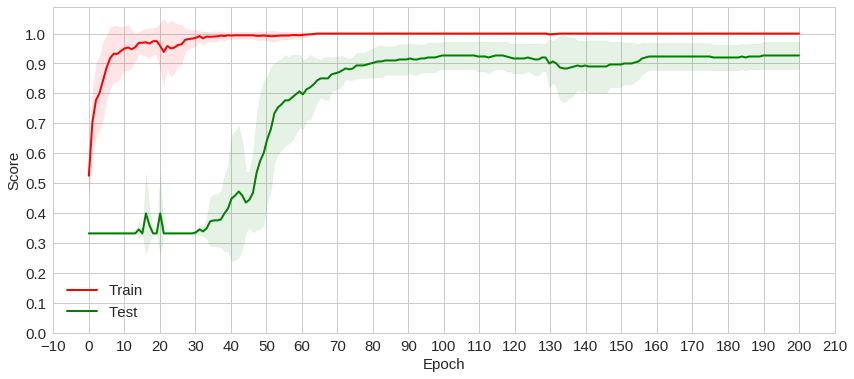

In [32]:
plot_mean_acc(hist)

In [33]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
plt.style.use('seaborn-whitegrid')

def plot_mean_loss(history):
    train_scores = np.zeros((len(history),len(history[0]['loss'])))
    for fold in range(len(history)):
        train_scores[fold] = history[fold]['loss']
    test_scores = np.zeros((len(history),len(history[0]['val_loss'])))
    for fold in range(len(history)):
        test_scores[fold] = history[fold]['val_loss']
    epochs = np.linspace(0, len(history[0]['loss']), len(history[0]['loss']))
    train_scores_mean = np.mean(train_scores, axis=0)
    train_scores_std = np.std(train_scores, axis=0)
    test_scores_mean = np.mean(test_scores, axis=0)
    test_scores_std = np.std(test_scores, axis=0)
    
    figsize=(14, 6)
    text_fontsize="medium"
    fig, ax = plt.subplots(1, 1, figsize=figsize)
    ax.set_xlabel("Epoch", fontsize=text_fontsize)
    ax.set_ylabel("Score", fontsize=text_fontsize)
    ax.grid(True)
    ax.yaxis.set_major_locator(ticker.MultipleLocator(1))
    ax.xaxis.set_major_locator(ticker.MultipleLocator(10))
    ax.fill_between(epochs, train_scores_mean - train_scores_std,
                    train_scores_mean + train_scores_std, alpha=0.1, color="r")
    ax.fill_between(epochs, test_scores_mean - test_scores_std,
                    test_scores_mean + test_scores_std, alpha=0.1, color="g")
    ax.plot(epochs, train_scores_mean, '-', color="r", linewidth=2.0, label="Train")
    ax.plot(epochs, test_scores_mean, '-', color="g", linewidth=2.0, alpha=0.7, label="Test")
    ax.tick_params(labelsize=text_fontsize)
    ax.legend(loc="best", fontsize=text_fontsize)
    x1,x2,y1,y2 = plt.axis()
    plt.axis((x1,x2,-0.9,10.9))
    plt.show()

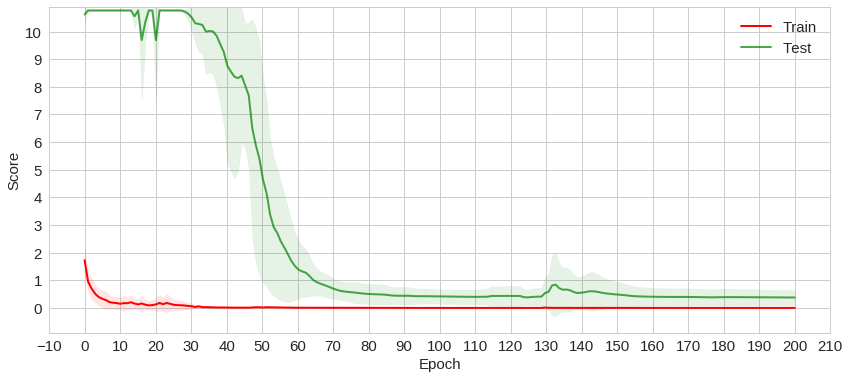

In [34]:
plot_mean_loss(hist)